In [1]:
import underworld as uw
import glucifer
import numpy as np
from underworld import function as fn

In [2]:
annulus = uw.mesh._FeMesh_Annulus(elementRes=(20,120), 
                                  radius=(2.0,4.), angularExtent=(0.0,360.0),
                                  periodic = [False, True])
tField = uw.mesh.MeshVariable(annulus, nodeDofCount=1)
vField = uw.mesh.MeshVariable(annulus, nodeDofCount=2)
pField = uw.mesh.MeshVariable(annulus.subMesh, nodeDofCount=1)


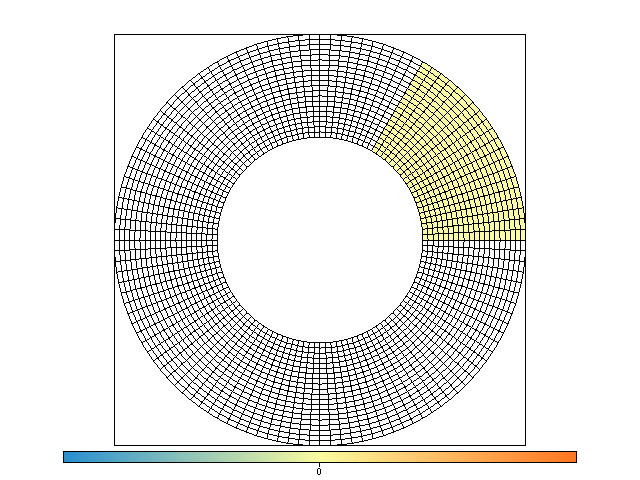


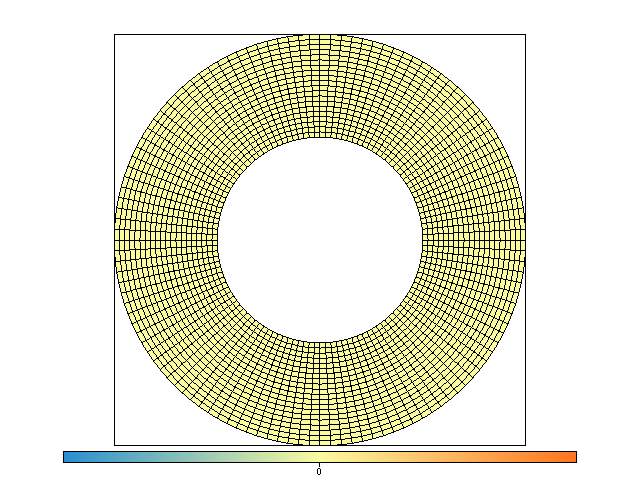

In [3]:
fig = glucifer.Figure()
fig.append(glucifer.objects.Mesh(annulus, segmentsPerEdge=1))
fig.append(glucifer.objects.Surface(annulus, tField, onMesh=True ))
fig.show()
fig.show()

In [4]:
jWalls = annulus.specialSets["MinJ_VertexSet"] + annulus.specialSets["MaxJ_VertexSet"]

In [5]:
t_outer = 5.0
t_inner = 10.0
outer = annulus.specialSets["MaxI_VertexSet"]
inner = annulus.specialSets["MinI_VertexSet"]

tField.data[inner.data] = 10.0
tField.data[outer.data] = 5.0

# setup parameters for temperature distribution
dr = annulus.radius[1] - annulus.radius[0]
dT_dr = (t_outer-t_inner)/(dr)
c0 = t_inner - dT_dr*annulus.radius[0]
# print c0, dT_dr

# wavenumber for perturbation
k = 4.

for ind,coord in enumerate(annulus.data):
    r = np.sqrt(coord[0]**2 + coord[1]**2)
    theta = np.arctan2(coord[1], coord[0])
    
    pert = np.sin((r-2.)*np.pi/dr)*np.cos(k*theta)
    
    t = r*dT_dr + c0
    tField.data[ind] = t + 1.*pert


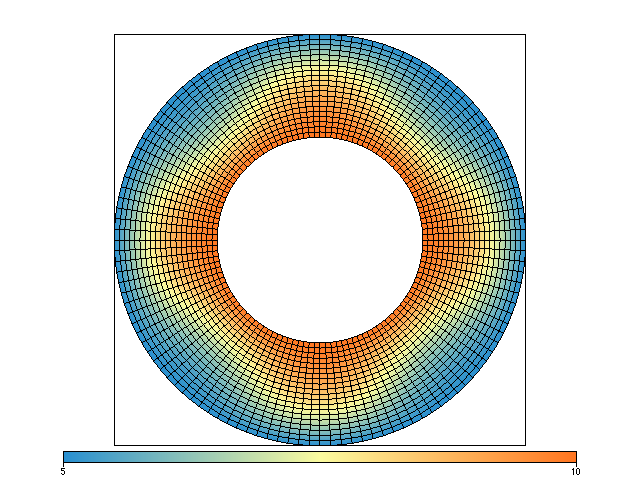

In [6]:
fig.show()

In [7]:
vBC = uw.conditions.DirichletCondition( variable=vField, indexSetsPerDof=(inner+outer, inner+outer))
tBC = uw.conditions.DirichletCondition( variable=tField, indexSetsPerDof=(inner+outer))

In [8]:
tDotField = uw.mesh.MeshVariable(annulus, nodeDofCount=1)
advDiffSLE = uw.systems.AdvectionDiffusion(tField, tDotField, vField, fn_diffusivity=1.0, conditions=tBC)

In [9]:
g  = -1.0*annulus._getRadiusFn()

In [10]:
bodyForceFn = g * tField

In [11]:
stokesSLE = uw.systems.Stokes( vField, pField, fn_viscosity=1.0, fn_bodyforce=bodyForceFn, conditions=vBC)

In [12]:
stokesSolver = uw.systems.Solver(stokesSLE)

In [13]:
stokesSolver.solve()

In [14]:
# vField.data[:] = g.evaluate(vField.mesh.data)

In [15]:
vField.data.max()

0.047982963480121758

In [16]:
# setup analysis function
vdotv = fn.math.dot(vField,vField)
v2sum_integral  = uw.utils.Integral( mesh=annulus, fn=vdotv )
volume_integral = uw.utils.Integral( mesh=annulus, fn=1. )
velmag = fn.math.sqrt(vdotv)
forcemag = fn.math.sqrt(fn.math.dot(bodyForceFn,bodyForceFn))


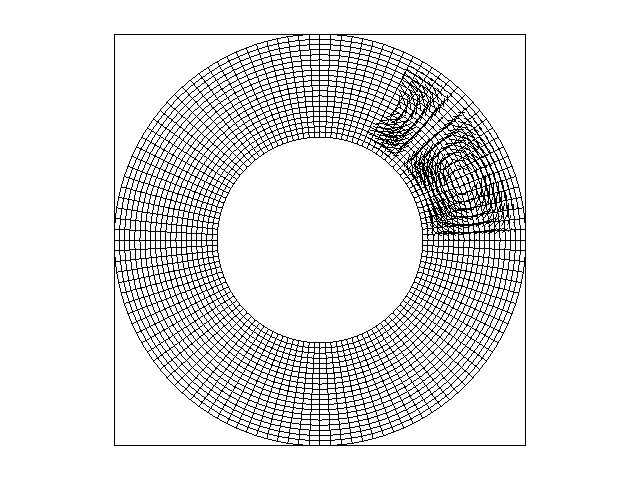


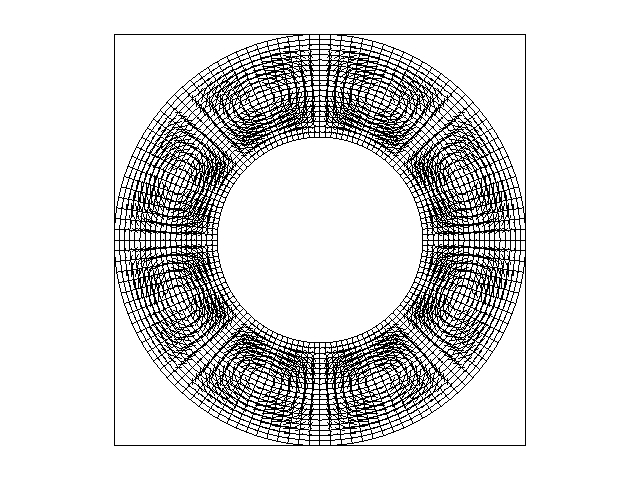

In [17]:
figV = glucifer.Figure(**fig)
figV.append(glucifer.objects.Mesh(annulus, segmentsPerEdge=1))
# figV.append(glucifer.objects.Surface(annulus, forcemag, onMesh=True))
figV.append(glucifer.objects.VectorArrows(annulus, vField*10., onMesh=True))
figV.show()
figV.show()

In [18]:
mH = annulus.save("mesh.h5")
vF = vField.save('v.h5', mH)
vField.xdmf("vF.xdmf", vF, 'velocity', mH, 'mesh')

In [19]:
!pwd

/home/julian/codes/testo
